In [47]:
import dataset as ds

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils import tensorboard
from torch.utils.data.dataloader import DataLoader
from pytorch_msssim import ssim as SSIM


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Part 1 - Datasets, Preprocessing and Data loading

In [23]:
def display_transforms(ds, idx):
    lr_image, hr_image = ds[idx]

    f, axes = plt.subplots(1,2, figsize=(10, 3))
    axes[0].set_title('Low Res')
    axes[0].imshow(lr_image.permute(1, 2, 0))
    axes[1].set_title('High Res')
    axes[1].imshow(hr_image.permute(1, 2, 0))


train_dataset = ds.SRDataset('./data', is_train=True)
test_dataset = ds.SRDataset('./data', is_train=False)
print(f" * Train dataset contains {len(train_dataset)} image(s).")
print(f" * Test dataset contains {len(test_dataset)} image(s).")
# display_transforms(train_dataset, 2)


 * Train dataset contains 301 image(s).
 * Test dataset contains 10 image(s).


## Part 2 - Create the Model

In [25]:
import model as ml

model = ml.BasicSRModel().to(device)
res_model = ml.ResidualSRModel().to(device)

## Part 3 - Training Loop

In [21]:
from trainer import train

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

learning_rate = 1e-6
epochs = 400

train(model, epochs, learning_rate, train_dataloader, test_dataloader)

Epoch #: 100%|██████████| 400/400 [1:04:24<00:00,  9.66s/it]


In [20]:
torch.save(model.state_dict(), "./models/basic_model")

In [27]:
model.load_state_dict(torch.load("./models/basic_model_400_1e4"))
res_model.load_state_dict(torch.load("./models/res_model_400_1e4"))

<All keys matched successfully>

In [ ]:
for _, batch in enumerate(train_dataloader, 0):
    lr_image_bilinear, hr_image = batch

    high_res_prediction = model(lr_image_bilinear.to(device))
    torchvision.io.write_png(lr_image_bilinear[0, ...].mul(255).byte(), "lr_image.png")
    torchvision.io.write_png(hr_image[0, ...].mul(255).byte(), "hr_image.png")
    torchvision.io.write_png(high_res_prediction.to('cpu')[0, ...].mul(255).byte(), "hr_image_pred.png")

## Part 4 - Model Evaluation

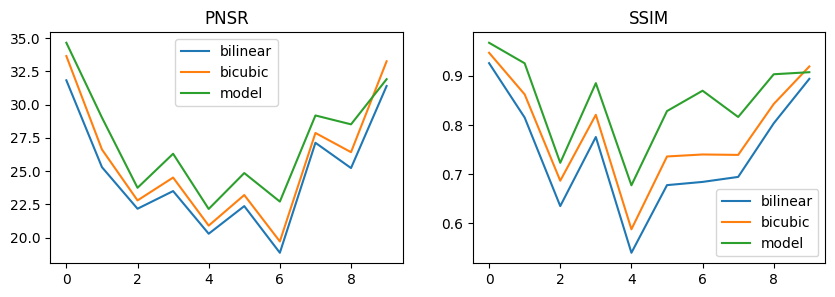

PSNR average on bilinear: 24.806352615356445
PSNR average on bicubic: 25.89361000061035
PSNR average on model: 27.302196502685547
SSIM average on bilinear: 0.7442458391189575
SSIM average on bicubic: 0.7880010426044464
SSIM average on model: 0.8503750383853912


In [42]:
from pytorch_msssim import ssim as SSIM

def psnr(image1, image2):
    mse_loss_func = torch.nn.MSELoss()
    return -10 * torch.log10(mse_loss_func(image1, image2))
def eval_model(model, dataset):
    eval_dataloader = DataLoader(dataset, batch_size=1)
    with torch.no_grad():
        psnr_bilinear = []
        psnr_bicubic = []
        psnr_model = []

        ssim_bilinear = []
        ssim_bicubic = []
        ssim_model = []
        for _, batch in enumerate(eval_dataloader):
            lr_image, hr_image = batch

            bilinear = torch.nn.functional.interpolate(lr_image, scale_factor=2, mode='bilinear')
            bicubic = torch.nn.functional.interpolate(lr_image, scale_factor=2, mode='bicubic')
            high_res_prediction = model(lr_image.to(device)).to('cpu')

            psnr_bilinear.append(psnr(bilinear, hr_image))
            psnr_bicubic.append(psnr(bicubic, hr_image))
            psnr_model.append(psnr(high_res_prediction, hr_image))

            ssim_bilinear.append(SSIM(bilinear, hr_image, data_range=1.0).item())
            ssim_bicubic.append(SSIM(bicubic, hr_image, data_range=1.0).item())
            ssim_model.append(SSIM(high_res_prediction, hr_image, data_range=1.0).item())

        f, axes = plt.subplots(1,2, figsize=(10, 3))
        axes[0].set_title('PNSR')
        axes[0].plot(psnr_bilinear, label='bilinear')
        axes[0].plot(psnr_bicubic, label='bicubic')
        axes[0].plot(psnr_model, label='model')
        axes[0].legend()
        axes[1].set_title('SSIM')
        axes[1].plot(ssim_bilinear, label='bilinear')
        axes[1].plot(ssim_bicubic, label='bicubic')
        axes[1].plot(ssim_model, label='model')
        axes[1].legend()
        plt.show()

        print(f"PSNR average on bilinear: {np.array(psnr_bilinear).mean()}")
        print(f"PSNR average on bicubic: {np.array(psnr_bicubic).mean()}")
        print(f"PSNR average on model: {np.array(psnr_model).mean()}")
        print(f"SSIM average on bilinear: {np.array(ssim_bilinear).mean()}")
        print(f"SSIM average on bicubic: {np.array(ssim_bicubic).mean()}")
        print(f"SSIM average on model: {np.array(ssim_model).mean()}")


eval_model(model, test_dataset)

Training logs on training dataset and validation logs on test dataset:  

<div>
<img src="plots/basic_400_1e4.jpg" width="800"/>
</div>


## Part 5 - Exploration  of different params and models

### Different Model
Residual model was created in Part 2 and trained by changing variable passed to trainer function.  

Comparing basic model with residual model on training logs on training dataset and validation logs on test dataset:  

<div>
<img src="plots/basic_and_residual_400_1e4.jpg" width="800"/>
</div>

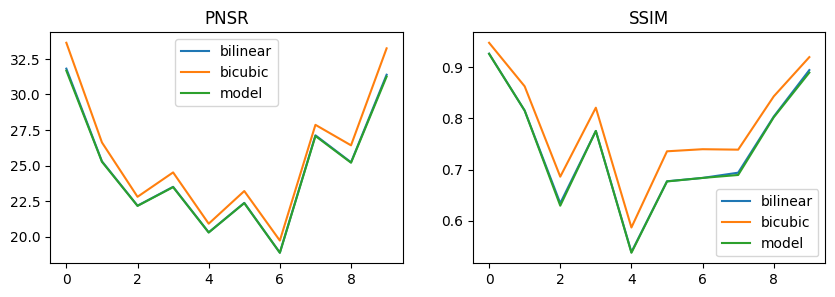

PSNR average on bilinear: 24.806352615356445
PSNR average on bicubic: 25.89361000061035
PSNR average on model: 24.7601261138916
SSIM average on bilinear: 0.7442458391189575
SSIM average on bicubic: 0.7880010426044464
SSIM average on model: 0.7424644410610199


In [41]:
eval_model(res_model)

### Effect of learning rate

Learning rate had dramatic effect on model usability, however I noticed that some results are beyond normal range, but I failed to figure out why.
Learning rate affects how quickly gradient descend descends (sorry) and therefore how quickly model will converge and how stable it will be.  

First we will compare how L1 loss changes with different learning rates on train and test set. Please notice that the Y-axis is log scale.

<div>
<img src="plots/basic_lr_train_l1.jpg" width=45%/>
&nbsp; &nbsp; &nbsp; &nbsp;
<img src="plots/basic_lr_test_l1.jpg" width=50%/>
</div>

Now PNSR and SSIM results:
<div>
<img src="plots/basic_lr_test_psnr.jpg" width=45%/>
&nbsp; &nbsp; &nbsp; &nbsp;
<img src="plots/basic_lr_test_ssim.jpg" width=48%/>
</div>

### Visual results and different downsampling methods  

#### Different downsampling methods  

In [50]:
from torchvision import transforms

nn_dataset = ds.SRDataset('./data', is_train=False, downsampling_method=transforms.InterpolationMode.NEAREST)
bicubic_dataset = ds.SRDataset('./data', is_train=False, downsampling_method=transforms.InterpolationMode.BICUBIC)

Evaluating on dataset downsampled with **Nearest Neighbor** method:

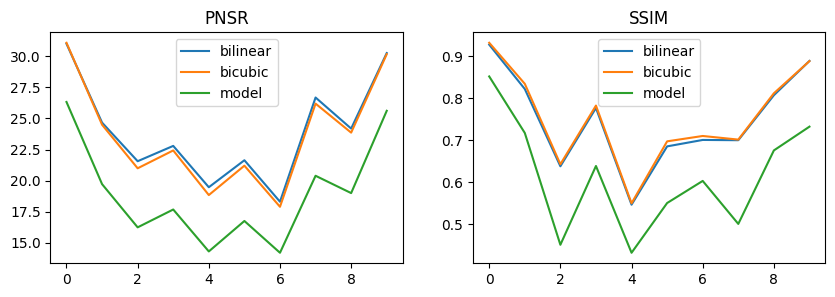

PSNR average on bilinear: 24.05860710144043
PSNR average on bicubic: 23.71746063232422
PSNR average on model: 19.019580841064453
SSIM average on bilinear: 0.7497421085834504
SSIM average on bicubic: 0.7555443227291108
SSIM average on model: 0.615835091471672


In [51]:
eval_model(model, nn_dataset)

Evaluating on dataset downsampled with **Bicubic** method:

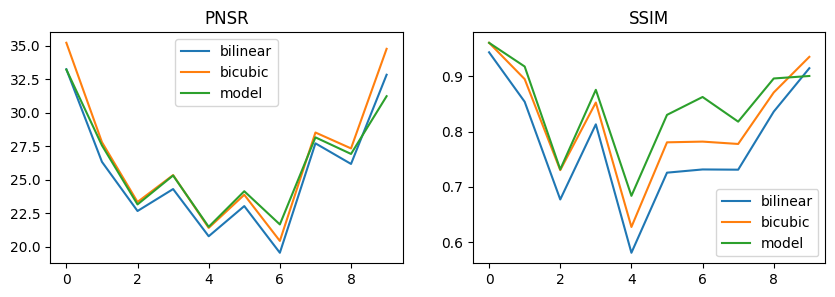

PSNR average on bilinear: 25.671493530273438
PSNR average on bicubic: 26.811054229736328
PSNR average on model: 26.29306411743164
SSIM average on bilinear: 0.7807176947593689
SSIM average on bicubic: 0.8212237000465393
SSIM average on model: 0.847751009464264


In [52]:
eval_model(model, bicubic_dataset)

#### Visual Results:

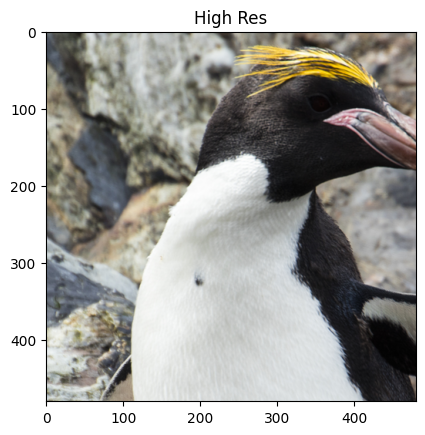

In [73]:
bilinear_dataloader = DataLoader(test_dataset, batch_size=1)
nn_dataloader = DataLoader(nn_dataset, batch_size=1)
bicubic_dataloader = DataLoader(bicubic_dataset, batch_size=1)


lr_image_bilinear, hr_image = next(iter(bilinear_dataloader))
lr_image_nn, _ = next(iter(nn_dataloader))
lr_image_bicubic, _ = next(iter(bicubic_dataloader))

model_bilinear = model(lr_image_bilinear.to(device)).to('cpu').detach()
model_nn = model(lr_image_nn.to(device)).to('cpu').detach()
model_bicubic = model(lr_image_bicubic.to(device)).to('cpu').detach()

res_model_bilinear = res_model(lr_image_bilinear.to(device)).to('cpu').detach()
res_model_nn = res_model(lr_image_nn.to(device)).to('cpu').detach()
res_model_bicubic = res_model(lr_image_bicubic.to(device)).to('cpu').detach()

plt.title('High Res')
plt.imshow(hr_image[0, ...].permute(1, 2, 0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


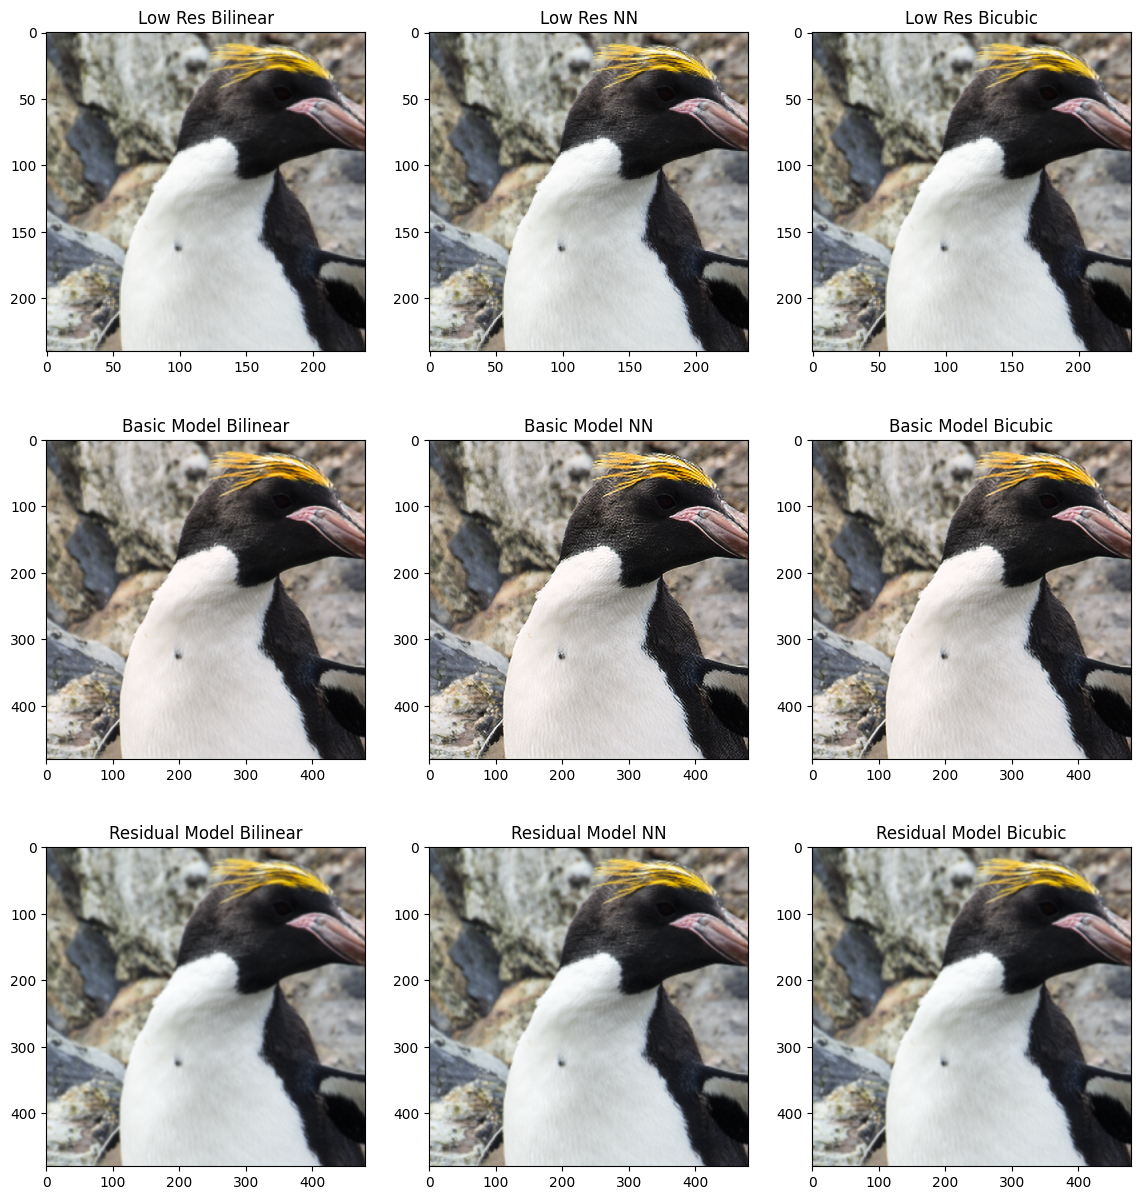

In [74]:
f, axes = plt.subplots(3,3, figsize=(14, 15))
axes[0][0].set_title('Low Res Bilinear')
axes[0][1].set_title('Low Res NN')
axes[0][2].set_title('Low Res Bicubic')
axes[0][0].imshow(lr_image_bilinear[0, ...].permute(1, 2, 0))
axes[0][1].imshow(lr_image_nn[0, ...].permute(1, 2, 0))
axes[0][2].imshow(lr_image_bicubic[0, ...].permute(1, 2, 0))

axes[1][0].set_title('Basic Model Bilinear')
axes[1][1].set_title('Basic Model NN')
axes[1][2].set_title('Basic Model Bicubic')
axes[1][0].imshow(model_bilinear[0, ...].permute(1, 2, 0))
axes[1][1].imshow(model_nn[0, ...].permute(1, 2, 0))
axes[1][2].imshow(model_bicubic[0, ...].permute(1, 2, 0))

axes[2][0].set_title('Residual Model Bilinear')
axes[2][1].set_title('Residual Model NN')
axes[2][2].set_title('Residual Model Bicubic')
axes[2][0].imshow(res_model_bilinear[0, ...].permute(1, 2, 0))
axes[2][1].imshow(res_model_nn[0, ...].permute(1, 2, 0))
axes[2][2].imshow(res_model_bicubic[0, ...].permute(1, 2, 0))
plt.show()